In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt

In [ ]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
mnist = MNIST(root="./data", train=True, transform=transform, download=True)
dataloader = DataLoader(mnist, batch_size=128, shuffle=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 16.0MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 487kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.41MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 10.0MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
class CVAE_Encoder(nn.Module):
    def __init__(self, input_dim, condition_dim, hidden_dim, latent_dim):
        super(CVAE_Encoder, self).__init__()
        self.fc1 = nn.Linear(input_dim + condition_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

    def forward(self, x, c):
        x_cond = torch.cat([x, c], dim=1)  # Concatenate image and condition
        h = torch.tanh(self.fc1(x_cond))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

In [ ]:
class CVAE_Decoder(nn.Module):
    def __init__(self, latent_dim, condition_dim, hidden_dim, output_dim):
        super(CVAE_Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim + condition_dim, hidden_dim)
        self.fc_out = nn.Linear(hidden_dim, output_dim)

    def forward(self, z, c):
        z_cond = torch.cat([z, c], dim=1)  # Concatenate latent variable and condition
        h = torch.tanh(self.fc1(z_cond))
        x_recon = torch.tanh(self.fc_out(h))
        return x_recon

In [ ]:
class CVAE(nn.Module):
    def __init__(self, input_dim, condition_dim, hidden_dim, latent_dim):
        super(CVAE, self).__init__()
        self.encoder = CVAE_Encoder(input_dim, condition_dim, hidden_dim, latent_dim)
        self.decoder = CVAE_Decoder(latent_dim, condition_dim, hidden_dim, input_dim)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x, c):
        mu, logvar = self.encoder(x, c)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decoder(z, c)
        return x_recon, mu, logvar


In [ ]:
def cvae_loss(x, x_recon, mu, logvar):
    reconstruction_loss = nn.MSELoss()(x_recon, x)
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return reconstruction_loss + 4*kl_divergence


In [ ]:
def show_images(images):
    plt.figure(figsize=(10, 10))
    for i in range(8):
        plt.subplot(1, 8, i + 1)
        plt.imshow(images[i].reshape(28, 28), cmap='gray')
        plt.axis('off')
    plt.show()

In [ ]:
# Model and optimizer
input_dim = 28 * 28
condition_dim = 10  # One-hot encoded classes
hidden_dim = 512
latent_dim = 20

model = CVAE(input_dim, condition_dim, hidden_dim, latent_dim)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

100%|██████████| 469/469 [00:19<00:00, 23.72it/s]


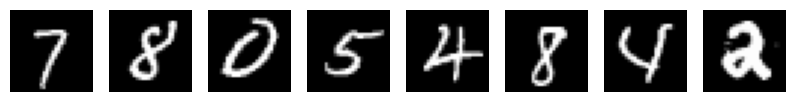

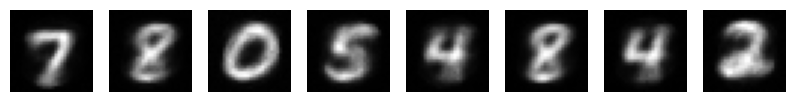

Epoch 1, Loss: 1.5437802076339722


100%|██████████| 469/469 [00:19<00:00, 24.37it/s]


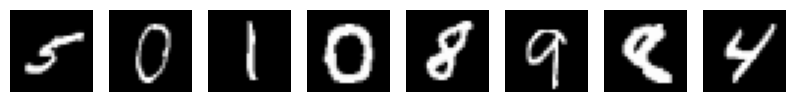

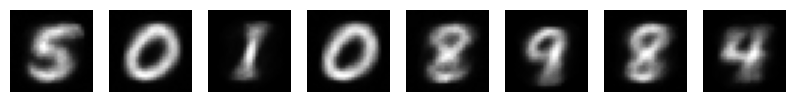

Epoch 2, Loss: 0.7798305749893188


100%|██████████| 469/469 [00:20<00:00, 23.08it/s]


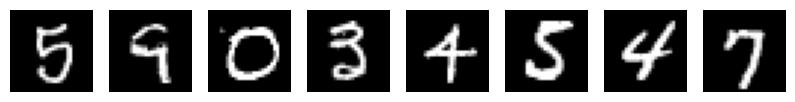

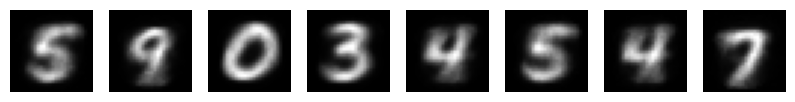

Epoch 3, Loss: 0.7420485615730286


100%|██████████| 469/469 [00:20<00:00, 23.36it/s]


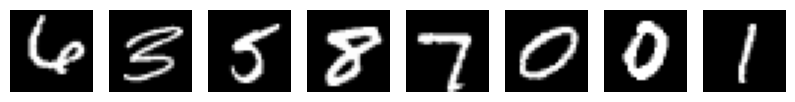

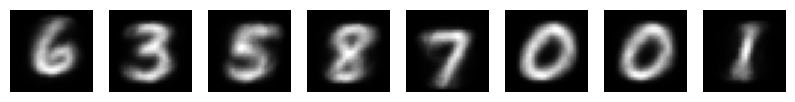

Epoch 4, Loss: 0.8773126602172852


100%|██████████| 469/469 [00:20<00:00, 23.20it/s]


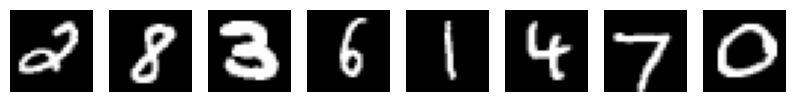

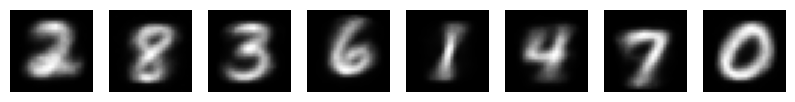

Epoch 5, Loss: 1.4179563522338867


100%|██████████| 469/469 [00:20<00:00, 23.20it/s]


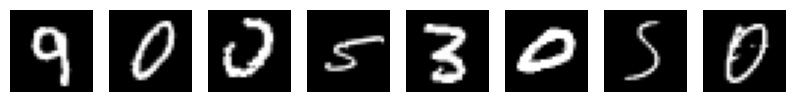

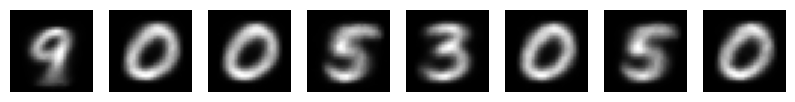

Epoch 6, Loss: 1.6026251316070557


100%|██████████| 469/469 [00:20<00:00, 23.14it/s]


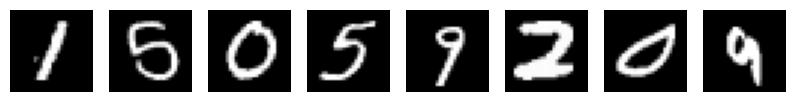

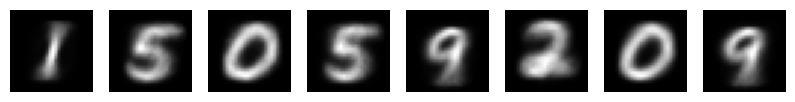

Epoch 7, Loss: 1.0480875968933105


100%|██████████| 469/469 [00:19<00:00, 23.90it/s]


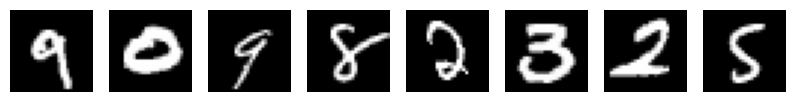

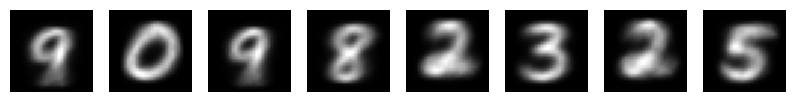

Epoch 8, Loss: 1.2593250274658203


100%|██████████| 469/469 [00:20<00:00, 23.01it/s]


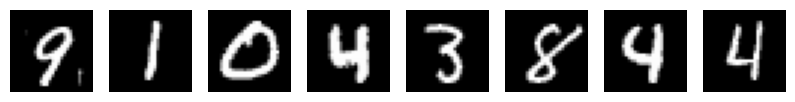

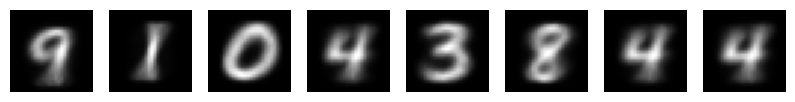

Epoch 9, Loss: 1.530914068222046


100%|██████████| 469/469 [00:20<00:00, 22.80it/s]


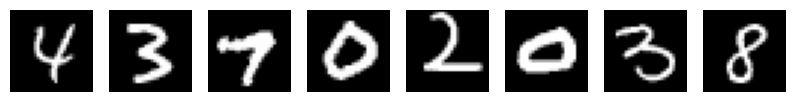

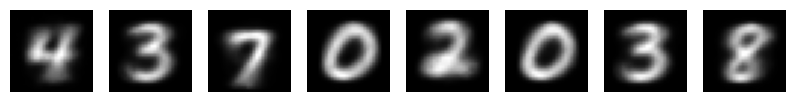

Epoch 10, Loss: 0.831412672996521


In [ ]:
# Training loop
for epoch in range(10):  # Number of epochs
    for images, labels in tqdm(dataloader):
        images = images.view(-1, 28 * 28)  # Flatten images
        labels = torch.eye(10)[labels]  # One-hot encode labels

        x_recon, mu, logvar = model(images, labels)
        loss = cvae_loss(images, x_recon, mu, logvar)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    show_images(images)
    show_images(x_recon.detach())
    print(f"Epoch {epoch + 1}, Loss: {loss.item()}")


In [ ]:
def generate_samples(model, label, num_samples=8):
    label = torch.eye(10)[label].repeat(num_samples, 1)  # One-hot encode label
    z = torch.randn(num_samples, latent_dim)  # Sample from standard normal
    with torch.no_grad():
        samples = model.decoder(z+3, label)
    return samples.view(-1, 1, 28, 28)  # Reshape to image format


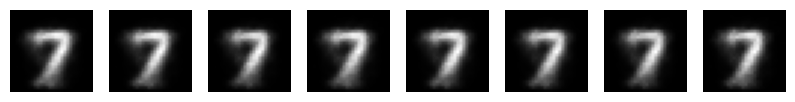

In [ ]:
show_images(generate_samples(model, 7))